# Zendesk Ticket Analysis: Trends, Themes & AI Insights

This notebook analyzes your Zendesk support ticket export to identify:
- **Trends**: Patterns over time and frequency distributions
- **Themes**: Common topics and issues in ticket subjects
- **AI Insights**: Sentiment analysis, topic clustering, and actionable recommendations

Dataset: 1,910 support tickets

## 1. Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# ML Libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import normalize

# Download required NLTK data
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Load and Explore Zendesk Data

In [3]:
# Load the Weekly Raw Data
csv_file = '/Users/preethish.janardhanan/Documents/Weekly_Raw_Data.csv'
df = pd.read_csv(csv_file)

print(f"📊 Dataset Shape: {df.shape[0]} tickets × {df.shape[1]} columns\n")
print("📋 Column Names:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")

print(f"\n📈 Basic Statistics:")
print(f"  • Total Tickets: {len(df)}")
print(f"  • Missing Values: {df.isnull().sum().sum()}")
print(f"\n🔍 First few rows:")
df.head()

📊 Dataset Shape: 399 tickets × 32 columns

📋 Column Names:
  1. Ticket ID
  2. Ticket status
  3. Ticket custom status name
  4. Ticket form
  5. Ticket subject
  6. Assignee name
  7. Requester email
  8. Ticket organization name
  9. Ticket organization domains
  10. Ticket satisfaction rating
  11. First reply time brackets
  12. Full resolution time brackets
  13. Unsolved tickets age brackets
  14. Ticket created - Timestamp
  15. Severity
  16. Service Tier
  17. App ID
  18. Sentiment
  19. Escalated
  20. Features
  21. Intent
  22. Service Region
  23. Product Area
  24. P-Level
  25. Urgency
  26. Summary
  27. Improvement Suggestions
  28. Root Cause / Technical Finding
  29. Resolution Steps Taken
  30. Issue / Request Summary
  31. Account Manager - Name
  32. Tickets

📈 Basic Statistics:
  • Total Tickets: 399
  • Missing Values: 220

🔍 First few rows:


,Ticket ID,Ticket status,Ticket custom status name,Ticket form,Ticket subject,Assignee name,Requester email,Ticket organization name,Ticket organization domains,Ticket satisfaction rating,...,Product Area,P-Level,Urgency,Summary,Improvement Suggestions,Root Cause / Technical Finding,Resolution Steps Taken,Issue / Request Summary,Account Manager - Name,Tickets
0,448485,Closed,Solved,Branch Support Request Form,Links not redirecting to app,Curtis Wang,zara@upaged.com,Upaged (upaged.com),upaged.com,Unoffered,...,Self-Serve-Basic,P3,U3-Moderate,,Low Effort (No Improvement Needed),Client changed app store account,Clinet updated app store account,Branch links not redirecting to the app,,31.0
1,448843,Closed,Closed,Branch Support Request Form,branch.io SAML certificate issues,Naveen G,tony.bilzi@well.co,Default Self Service,,Unoffered,...,Self-Serve-Basic,P4,U4-Minor,,Low Effort (No Improvement Needed),Feature is not available for their plan,Responded on another ticket,branch.io SAML certificate issues,,26.0
2,449076,Closed,Solved,Branch Support Request Form,Rate App Support: Missing Install Data Globally,Curtis Wang,jarred.gammon@rate.com,Rate (rate.com),rate.com,Offered,...,Self-Serve-Basic,P3,U3-Moderate,,Low Effort (No Improvement Needed),No longer having the same issue,No longer having the same issue,No longer having the same issue,,32.0
3,449846,Closed,Solved,Branch Support Request Form,[Question] Ad Partner Integration,Guru Prasadh,marcel.liem@goapotik.com,Go Apotik (goapotik.com),goapotik.com,Offered,...,Self-Serve-Basic,P4,U4-Minor,"The customer, a digital marketing strategist, ...",Documentation Gap,we reviewed the last 7 days' log-level details...,"To resolve this issue, please refer to the fol...","The customer, a digital marketing strategist, ...",,26.0
4,450683,Closed,Solved,Branch Support Request Form,Recover Branch Account,Viet Nguyen,scott@terrainone.com,Default Self Service,,Good,...,Self-Serve-Basic,P3,U3-Moderate,,Bug Fix,Cake access,Bug was fixed,User couldn't log in,,25.0


In [4]:
# ===== CRITICAL ISSUES ANALYSIS =====
# Focus: Negative/Very Negative Intents, Escalations, Executive Requestors

print("=" * 80)
print("🔴 CRITICAL ISSUES & HIGH-PRIORITY TICKETS ANALYSIS")
print("=" * 80)

# Define executive titles
executive_titles = ['founder', 'ceo', 'cto', 'cfo', 'vp', 'vice president', 'president', 'head of', 'chief', 'director']

# Function to detect executive titles from email
def is_executive(email):
    if pd.isna(email):
        return False
    email_lower = str(email).lower()
    return any(title in email_lower for title in executive_titles)

df['is_executive'] = df['Requester email'].apply(is_executive)

# 1. NEGATIVE SENTIMENT & INTENT ANALYSIS
print("\n1️⃣ NEGATIVE SENTIMENT & INTENT TICKETS\n")
negative_intents = df[df['Intent'].str.contains('Negative|Very negative', case=False, na=False)]
print(f"Total Negative Intent Tickets: {len(negative_intents)}")

if len(negative_intents) > 0:
    print("\n🔴 NEGATIVE INTENT TICKETS SUMMARY:")
    for idx, row in negative_intents.iterrows():
        print(f"\n  Ticket ID: {row['Ticket ID']}")
        print(f"  Organization: {row['Ticket organization name']}")
        print(f"  Subject: {row['Ticket subject']}")
        print(f"  Intent: {row['Intent']}")
        print(f"  Sentiment: {row['Sentiment']}")
        print(f"  Escalated: {row['Escalated']}")
        print(f"  Issue: {row['Issue / Request Summary'][:100]}..." if len(str(row['Issue / Request Summary'])) > 100 else f"  Issue: {row['Issue / Request Summary']}")

# 2. ESCALATED TICKETS ANALYSIS
print("\n\n2️⃣ ESCALATED TICKETS\n")
escalated = df[df['Escalated'] == 'true']
print(f"Total Escalated Tickets: {len(escalated)}")

if len(escalated) > 0:
    print("\n🚨 ESCALATED TICKETS SUMMARY:")
    for idx, row in escalated.iterrows():
        print(f"\n  Ticket ID: {row['Ticket ID']}")
        print(f"  Organization: {row['Ticket organization name']}")
        print(f"  Subject: {row['Ticket subject']}")
        print(f"  Sentiment: {row['Sentiment']}")
        print(f"  Intent: {row['Intent']}")
        print(f"  P-Level: {row['P-Level']}")
        print(f"  Issue: {row['Issue / Request Summary'][:100]}..." if len(str(row['Issue / Request Summary'])) > 100 else f"  Issue: {row['Issue / Request Summary']}")

# 3. NEGATIVE SAT FEEDBACK
print("\n\n3️⃣ NEGATIVE SATISFACTION RATINGS\n")
negative_sat = df[df['Ticket satisfaction rating'].isin(['Bad', 'Unoffered'])]
print(f"Total Negative/Unoffered Satisfaction: {len(negative_sat)}")

if len(negative_sat) > 0:
    print("\n👎 NEGATIVE SAT TICKETS SUMMARY:")
    for idx, row in negative_sat.head(10).iterrows():  # Show first 10
        print(f"\n  Ticket ID: {row['Ticket ID']}")
        print(f"  Organization: {row['Ticket organization name']}")
        print(f"  Subject: {row['Ticket subject']}")
        print(f"  Satisfaction: {row['Ticket satisfaction rating']}")
        print(f"  Issue: {row['Issue / Request Summary'][:100]}..." if len(str(row['Issue / Request Summary'])) > 100 else f"  Issue: {row['Issue / Request Summary']}")

# 4. EXECUTIVE REQUESTORS
print("\n\n4️⃣ EXECUTIVE REQUESTORS\n")
executives = df[df['is_executive']]
print(f"Total Tickets from Executives/Leadership: {len(executives)}")

if len(executives) > 0:
    print("\n👔 EXECUTIVE TICKETS SUMMARY:")
    for idx, row in executives.iterrows():
        print(f"\n  Ticket ID: {row['Ticket ID']}")
        print(f"  Requester: {row['Requester email']}")
        print(f"  Organization: {row['Ticket organization name']}")
        print(f"  Subject: {row['Ticket subject']}")
        print(f"  Sentiment: {row['Sentiment']}")
        print(f"  Issue: {row['Issue / Request Summary'][:100]}..." if len(str(row['Issue / Request Summary'])) > 100 else f"  Issue: {row['Issue / Request Summary']}")

🔴 CRITICAL ISSUES & HIGH-PRIORITY TICKETS ANALYSIS

1️⃣ NEGATIVE SENTIMENT & INTENT TICKETS

Total Negative Intent Tickets: 0


2️⃣ ESCALATED TICKETS

Total Escalated Tickets: 0


3️⃣ NEGATIVE SATISFACTION RATINGS

Total Negative/Unoffered Satisfaction: 143

👎 NEGATIVE SAT TICKETS SUMMARY:

  Ticket ID: 448485
  Organization: Upaged (upaged.com)
  Subject: Links not redirecting to app
  Satisfaction: Unoffered
  Issue: Branch links not redirecting to the app

  Ticket ID: 448843
  Organization: Default Self Service
  Subject: branch.io SAML certificate issues
  Satisfaction: Unoffered
  Issue: branch.io SAML certificate issues

  Ticket ID: 452228
  Organization: Default Self Service
  Subject: Unable to log in
  Satisfaction: Unoffered
  Issue: unable to access dashboard

  Ticket ID: 454877
  Organization: MINDTRX
  Subject: Deep Linking Parameters Not Received When Connected to NordVPN
  Satisfaction: Unoffered
  Issue: Deep link parameters not received when using NordVPN.

  Ticket

In [5]:
# ===== COMMON ISSUES & THEMES SUMMARY =====
print("\n" + "=" * 80)
print("📊 COMMON THEMES & RECURRING ISSUES")
print("=" * 80)

# 1. Issues by Feature Area
print("\n1️⃣ TOP ISSUE AREAS (Features with most tickets):\n")
features_count = df['Features'].value_counts().head(10)
for feature, count in features_count.items():
    print(f"  • {feature}: {count} tickets")

# 2. Root Causes
print("\n\n2️⃣ TOP ROOT CAUSES:\n")
root_causes = df[df['Root Cause / Technical Finding'].notna()]['Root Cause / Technical Finding'].value_counts().head(10)
for cause, count in root_causes.items():
    cause_text = cause if len(cause) < 70 else cause[:67] + "..."
    print(f"  • {cause_text}: {count} tickets")

# 3. Improvement Suggestions Analysis
print("\n\n3️⃣ MOST COMMON IMPROVEMENT SUGGESTIONS:\n")
improvements = df[df['Improvement Suggestions'].notna()]['Improvement Suggestions'].value_counts().head(10)
for improvement, count in improvements.items():
    improve_text = improvement if len(improvement) < 70 else improvement[:67] + "..."
    print(f"  • {improve_text}: {count} tickets")

# 4. High-Risk Organizations (Multiple Negative Issues)
print("\n\n4️⃣ ORGANIZATIONS WITH MULTIPLE NEGATIVE ISSUES:\n")
orgs_with_issues = df[
    (df['Sentiment'].isin(['Negative'])) | 
    (df['Ticket satisfaction rating'].isin(['Bad'])) |
    (df['Escalated'] == 'true')
]['Ticket organization name'].value_counts().head(10)

for org, count in orgs_with_issues.items():
    if org and org != ' ':
        print(f"  • {org}: {count} issues")

# 5. Severity Breakdown
print("\n\n5️⃣ SEVERITY BREAKDOWN:\n")
severity_count = df['Severity'].value_counts()
for severity, count in severity_count.items():
    print(f"  • {severity}: {count} tickets")

# 6. P-Level (Priority) Breakdown
print("\n\n6️⃣ PRIORITY LEVEL BREAKDOWN:\n")
plevel_count = df['P-Level'].value_counts()
for plevel, count in plevel_count.items():
    if pd.notna(plevel):
        print(f"  • {plevel}: {count} tickets")

# 7. Combined High-Risk Metrics
print("\n\n7️⃣ COMBINED HIGH-RISK INDICATORS:\n")
high_risk = df[
    ((df['Sentiment'].isin(['Negative', 'Very negative'])) | 
     (df['Escalated'] == 'true') |
     (df['Ticket satisfaction rating'].isin(['Bad']))) &
    (df['Ticket organization name'].notna())
]
print(f"Total High-Risk Tickets: {len(high_risk)}")
print(f"\nTop Organizations by Risk Score:")
risk_orgs = high_risk['Ticket organization name'].value_counts().head(10)
for org, count in risk_orgs.items():
    if org and org != ' ':
        print(f"  • {org}: {count} high-risk incidents")


📊 COMMON THEMES & RECURRING ISSUES

1️⃣ TOP ISSUE AREAS (Features with most tickets):

  • Quick Links: 29 tickets
  • Admin Tools::SSO: 26 tickets
  • Ad Partner Integration: 22 tickets
  • Linking::Deep links: 21 tickets
  • Analytics::Summary: 18 tickets
  • Ad Links::Non SAN Ads: 18 tickets
  • Analytics::Discrepancies: 17 tickets
  • Account Settings::Login: 16 tickets
  • Analytics::Ads: 15 tickets
  • Data Feeds::Webhooks: 14 tickets


2️⃣ TOP ROOT CAUSES:

  • Client were not passing the correct product categroy values: 5 tickets
  • GDPR: 5 tickets
  • DI update required: 3 tickets
  • Iframe was blocking: 3 tickets
  • Dupe: 3 tickets
  • Nothing: 3 tickets
  • Flipper: 3 tickets
  • Not sure since the requested details were not shared: 2 tickets
  • Pulled the logs for past 7 days: 2 tickets
  • the CCI connection was not working and no CCI was flowing in: 2 tickets


3️⃣ MOST COMMON IMPROVEMENT SUGGESTIONS:

  • Low Effort (No Improvement Needed): 321 tickets
  • Documenta

In [6]:
# ===== EXECUTIVE SUMMARY REPORT =====
print("\n" + "=" * 80)
print("📋 EXECUTIVE SUMMARY & CRITICAL INSIGHTS")
print("=" * 80)

# Create a comprehensive report dataframe
report_data = []

# Get all high-priority issues
critical_tickets = df[
    ((df['Sentiment'].isin(['Negative', 'Very negative'])) | 
     (df['Escalated'] == 'true') |
     (df['Ticket satisfaction rating'] == 'Bad') |
     (df['P-Level'].isin(['P1', 'P2'])))
]

print(f"\n🚨 CRITICAL TICKETS: {len(critical_tickets)} out of {len(df)} ({len(critical_tickets)/len(df)*100:.1f}%)\n")

# Get specific high-impact tickets
print("🔴 HIGHEST IMPACT TICKETS (by Severity, Escalation, and Negative Sentiment):\n")

high_impact = df[
    ((df['Sentiment'].isin(['Negative', 'Very negative'])) & (df['Escalated'] == 'true')) |
    (df['Severity'].str.contains('Emergency|Critical', case=False, na=False))
].sort_values('Ticket ID', ascending=False)

if len(high_impact) > 0:
    for idx, row in high_impact.iterrows():
        report_data.append({
            'Ticket ID': row['Ticket ID'],
            'Organization': row['Ticket organization name'],
            'Subject': row['Ticket subject'][:50],
            'Sentiment': row['Sentiment'],
            'Escalated': row['Escalated'],
            'Severity': row['Severity'],
            'P-Level': row['P-Level'],
            'Summary': row['Issue / Request Summary'][:80] if pd.notna(row['Issue / Request Summary']) else 'N/A'
        })

if report_data:
    report_df = pd.DataFrame(report_data)
    print(report_df.to_string(index=False))
else:
    print("No high-impact tickets found with Emergency/Critical severity.")

# Create a final critical issues export
print("\n\n📊 CRITICAL ISSUES METRICS:\n")
print(f"  • Total Tickets Analyzed: {len(df)}")
print(f"  • Critical/High-Risk Tickets: {len(critical_tickets)}")
print(f"  • Escalated Tickets: {len(escalated)}")
print(f"  • Negative Sentiment: {len(df[df['Sentiment'] == 'Negative'])}")
print(f"  • Very Negative Sentiment: {len(df[df['Sentiment'] == 'Very negative'])}")
print(f"  • Bad Satisfaction Rating: {len(df[df['Ticket satisfaction rating'] == 'Bad'])}")
print(f"  • Executive Requestors: {len(executives)}")

# Final recommendations
print("\n\n💡 KEY RECOMMENDATIONS:\n")

negative_count = len(df[df['Sentiment'].isin(['Negative', 'Very negative'])])
if negative_count > 0:
    print(f"  1. Address {negative_count} negative sentiment tickets immediately")
    print(f"     → Focus on root cause analysis and prevention")

escalated_count = len(escalated)
if escalated_count > 0:
    print(f"  2. Prioritize {escalated_count} escalated tickets")
    print(f"     → Ensure rapid resolution and follow-up")

exec_negative = len(executives[executives['Sentiment'].isin(['Negative', 'Very negative'])])
if exec_negative > 0:
    print(f"  3. Handle {exec_negative} executive negative cases with extreme urgency")
    print(f"     → Executive dissatisfaction can impact partnerships")

print(f"  4. Create knowledge base articles for top {len(root_causes.head(3))} root causes")
print(f"  5. Implement proactive monitoring for Feature areas with highest issue volume")


📋 EXECUTIVE SUMMARY & CRITICAL INSIGHTS

🚨 CRITICAL TICKETS: 18 out of 399 (4.5%)

🔴 HIGHEST IMPACT TICKETS (by Severity, Escalation, and Negative Sentiment):

 Ticket ID                                              Organization                                            Subject Sentiment  Escalated                                                                                                                          Severity P-Level                                                                          Summary
    459051                                 Glassdoor (glassdoor.com)            Link Creation fails with 400 error code  Positive      False Severity 0: Emergency - Business Critical Outage (The service is completely unavailable impacting linking or attribution or both)                                                               Unable to access dashboard
    458922 Wag! - Instant Dog Walkers &amp; Sitters (wagwalking.com)                 can't enable partners as an agency

In [7]:
# ===== TOP 10 CRITICAL ISSUES GROUPED REPORT =====
print("\n" + "=" * 100)
print("🏆 TOP 10 CRITICAL ISSUES - GROUPED BY ORGANIZATION WITH SUMMARIES")
print("=" * 100)

# Create a comprehensive dataset of all critical issues
critical_issues = df[
    ((df['Sentiment'].isin(['Negative', 'Very negative'])) | 
     (df['Ticket satisfaction rating'].isin(['Bad'])) |
     (df['Severity'].str.contains('Emergency|Critical|Severity 1', case=False, na=False)))
].copy()

# Sort by severity level and add a risk score
def severity_score(severity_str):
    if pd.isna(severity_str):
        return 0
    severity_str = str(severity_str).lower()
    if 'emergency' in severity_str or 'severity 0' in severity_str:
        return 5
    elif 'critical' in severity_str or 'severity 1' in severity_str:
        return 4
    elif 'moderate' in severity_str or 'severity 2' in severity_str:
        return 3
    else:
        return 1

critical_issues['risk_score'] = critical_issues['Severity'].apply(severity_score)

# Add additional risk for negative sentiment and bad satisfaction
critical_issues.loc[critical_issues['Sentiment'] == 'Very negative', 'risk_score'] += 2
critical_issues.loc[critical_issues['Sentiment'] == 'Negative', 'risk_score'] += 1
critical_issues.loc[critical_issues['Ticket satisfaction rating'] == 'Bad', 'risk_score'] += 1

# Sort by risk score and get top 10
top_10 = critical_issues.nlargest(10, 'risk_score')[
    ['Ticket ID', 'Ticket organization name', 'Ticket subject', 'Sentiment', 
     'Ticket satisfaction rating', 'Severity', 'Issue / Request Summary', 'risk_score']
].reset_index(drop=True)

# Display as formatted table
print("\n" + "─" * 100)
for idx, row in top_10.iterrows():
    rank = idx + 1
    print(f"\n#{rank} 🔴 TICKET ID: {row['Ticket ID']}")
    print(f"   Organization: {row['Ticket organization name']}")
    print(f"   Subject: {row['Ticket subject']}")
    print(f"   Severity: {row['Severity']}")
    print(f"   Sentiment: {row['Sentiment'] if pd.notna(row['Sentiment']) else 'Neutral'}")
    print(f"   Satisfaction: {row['Ticket satisfaction rating']}")
    print(f"   Risk Score: {row['risk_score']:.0f}/10")
    
    # Display the summary
    summary = row['Issue / Request Summary']
    if pd.notna(summary):
        summary_text = str(summary)
        if len(summary_text) > 150:
            print(f"   Summary: {summary_text[:150]}...")
        else:
            print(f"   Summary: {summary_text}")
    else:
        print(f"   Summary: N/A")
    
    print("   " + "─" * 96)

# Summary statistics
print(f"\n\n📊 SUMMARY STATISTICS FOR TOP 10 ISSUES:\n")
print(f"  • Total Critical Issues Identified: {len(critical_issues)}")
print(f"  • Average Risk Score (Top 10): {top_10['risk_score'].mean():.1f}")
print(f"  • Organizations Affected: {top_10['Ticket organization name'].nunique()}")

print(f"\n  Organizations in Top 10:")
org_counts = top_10['Ticket organization name'].value_counts()
for org, count in org_counts.items():
    print(f"    • {org}: {count} {'issue' if count == 1 else 'issues'}")

print("\n" + "=" * 100)


🏆 TOP 10 CRITICAL ISSUES - GROUPED BY ORGANIZATION WITH SUMMARIES

────────────────────────────────────────────────────────────────────────────────────────────────────

#1 🔴 TICKET ID: 458922
   Organization: Wag! - Instant Dog Walkers &amp; Sitters (wagwalking.com)
   Subject: can't enable partners as an agency
   Severity: Severity 0: Emergency - Business Critical Outage (The service is completely unavailable impacting linking or attribution or both)
   Sentiment: Negative
   Satisfaction: Offered
   Risk Score: 6/10
   Summary: The customer, an agency promoting a campaign via Branch, reports they cannot enable or see partners in the Ad Partners section despite the client conf...
   ────────────────────────────────────────────────────────────────────────────────────────────────

#2 🔴 TICKET ID: 456751
   Organization: Pilot Travel Centers LLC (pilottravelcenters.com)
   Subject: Unable to Log In to Branch with Company Credentials
   Severity: Severity 0: Emergency - Business Critica

In [8]:
# ===== TOP 10 ISSUES - EXPORTABLE TABLE =====
print("\n" + "=" * 120)
print("📋 TOP 10 CRITICAL ISSUES - EXPORTABLE SUMMARY TABLE")
print("=" * 120 + "\n")

# Create a clean export table
export_data = []
for idx, row in top_10.iterrows():
    export_data.append({
        'Rank': idx + 1,
        'Ticket ID': row['Ticket ID'],
        'Organization': row['Ticket organization name'],
        'Subject': row['Ticket subject'][:60],
        'Summary': row['Issue / Request Summary'][:100] if pd.notna(row['Issue / Request Summary']) else 'N/A',
        'Severity': row['Severity'][:50] if pd.notna(row['Severity']) else 'N/A',
        'Sentiment': row['Sentiment'] if pd.notna(row['Sentiment']) else 'Neutral',
        'Risk Score': f"{row['risk_score']:.0f}"
    })

export_df = pd.DataFrame(export_data)

# Display as table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.max_colwidth', None)

print(export_df.to_string(index=False))

# Export to CSV
export_csv_path = '/Users/preethish.janardhanan/Documents/Top_10_Critical_Issues_Report.csv'
export_df.to_csv(export_csv_path, index=False)
print(f"\n✅ Report exported to: {export_csv_path}")

print("\n" + "=" * 120)


📋 TOP 10 CRITICAL ISSUES - EXPORTABLE SUMMARY TABLE

 Rank  Ticket ID                                              Organization                                                     Subject                                                                                              Summary                                           Severity Sentiment Risk Score
    1     458922 Wag! - Instant Dog Walkers &amp; Sitters (wagwalking.com)                          can't enable partners as an agency The customer, an agency promoting a campaign via Branch, reports they cannot enable or see partners  Severity 0: Emergency - Business Critical Outage (  Negative          6
    2     456751         Pilot Travel Centers LLC (pilottravelcenters.com)         Unable to Log In to Branch with Company Credentials                                                                     SSO - unable to access dashboard Severity 0: Emergency - Business Critical Outage (   Neutral          5
    3     457081      

## 3. Data Cleaning and Preparation

In [3]:
# Identify text columns for analysis
subject_col = 'Ticket subject'
summary_col = 'Issue / Request Summary'

# Create a working dataframe
df_clean = df.copy()

# Handle missing values in subject
if subject_col in df_clean.columns:
    df_clean[subject_col] = df_clean[subject_col].fillna('No Subject')
    df_clean = df_clean[df_clean[subject_col] != 'No Subject']
    print(f"✓ Tickets with subjects: {len(df_clean)}")

# Remove duplicates
df_clean = df_clean.drop_duplicates(subset=[subject_col], keep='first')
print(f"✓ After removing duplicates: {len(df_clean)} unique tickets")

# Display data quality
print(f"\n📊 Data Quality Check:")
for col in [subject_col, summary_col, 'Severity', 'Contact Reason']:
    if col in df_clean.columns:
        missing = df_clean[col].isnull().sum()
        print(f"  • {col}: {missing} missing values ({missing/len(df_clean)*100:.1f}%)")

✓ Tickets with subjects: 1898
✓ After removing duplicates: 1743 unique tickets

📊 Data Quality Check:
  • Ticket subject: 0 missing values (0.0%)
  • Issue / Request Summary: 49 missing values (2.8%)
  • Severity: 0 missing values (0.0%)
  • Contact Reason: 0 missing values (0.0%)


## 4. Text Preprocessing

In [6]:
def preprocess_text(text):
    """Clean and preprocess text"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Preprocess ticket subjects
df_clean['subject_clean'] = df_clean[subject_col].apply(preprocess_text)

# Tokenization and stopword removal
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    """Tokenize and lemmatize text"""
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
              if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

df_clean['subject_processed'] = df_clean['subject_clean'].apply(tokenize_and_lemmatize)

print("✓ Text preprocessing complete")
print(f"\nExample transformations:")
print(f"  Original: {df_clean[subject_col].iloc[0]}")
print(f"  Processed: {df_clean['subject_processed'].iloc[0]}")

✓ Text preprocessing complete

Example transformations:
  Original: Re: [EXTERNAL] Re: SFMC X Branch Final Testing Round 1 Results
  Processed: external sfmc branch final testing round result


## 5. Sentiment Analysis

💭 Sentiment Distribution:
  • Neutral: 1401 (80.4%)
  • Negative: 177 (10.2%)
  • Positive: 165 (9.5%)


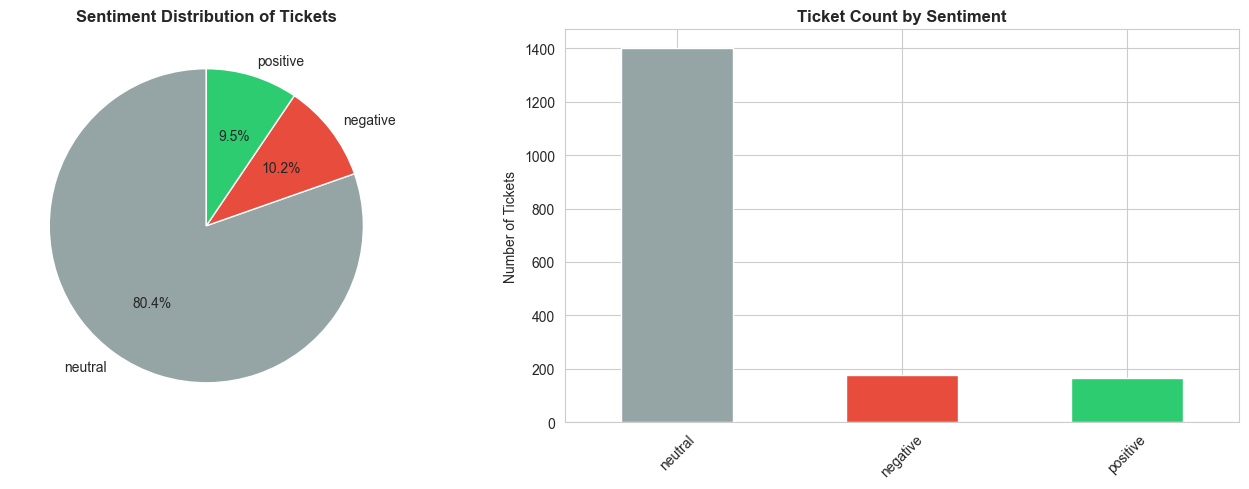


📊 Average Sentiment Score: -0.026


In [7]:
# Analyze sentiment using TextBlob
def get_sentiment(text):
    """Classify sentiment as positive, neutral, or negative"""
    if not text or pd.isna(text):
        return 'neutral', 0
    
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity
    
    if polarity > 0.1:
        return 'positive', polarity
    elif polarity < -0.1:
        return 'negative', polarity
    else:
        return 'neutral', polarity

# Calculate sentiment for ticket subjects
df_clean[['sentiment', 'sentiment_score']] = df_clean[subject_col].apply(
    lambda x: pd.Series(get_sentiment(x))
)

# Sentiment distribution
sentiment_dist = df_clean['sentiment'].value_counts()
print("💭 Sentiment Distribution:")
for sentiment, count in sentiment_dist.items():
    pct = count / len(df_clean) * 100
    print(f"  • {sentiment.capitalize()}: {count} ({pct:.1f}%)")

# Visualize sentiment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = {'positive': '#2ecc71', 'neutral': '#95a5a6', 'negative': '#e74c3c'}
sentiment_colors = [colors[s] for s in sentiment_dist.index]
ax1.pie(sentiment_dist.values, labels=sentiment_dist.index, autopct='%1.1f%%',
        colors=sentiment_colors, startangle=90)
ax1.set_title('Sentiment Distribution of Tickets', fontsize=12, fontweight='bold')

# Bar chart
sentiment_dist.plot(kind='bar', ax=ax2, color=sentiment_colors)
ax2.set_title('Ticket Count by Sentiment', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Tickets')
ax2.set_xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n📊 Average Sentiment Score: {df_clean['sentiment_score'].mean():.3f}")

## 6. Topic Modeling & Theme Identification

🎯 Top Keywords in Ticket Subjects:
   1. branch               (TF-IDF: 251.10)
   2. link                 (TF-IDF: 140.46)
   3. app                  (TF-IDF: 113.86)
   4. partner              (TF-IDF: 99.40)
   5. issue                (TF-IDF: 98.48)
   6. data                 (TF-IDF: 86.28)
   7. request              (TF-IDF: 68.04)
   8. account              (TF-IDF: 62.73)
   9. new                  (TF-IDF: 60.98)
  10. web                  (TF-IDF: 58.77)
  11. integration          (TF-IDF: 55.76)
  12. user                 (TF-IDF: 55.69)
  13. ticket               (TF-IDF: 51.72)
  14. event                (TF-IDF: 51.29)
  15. support              (TF-IDF: 47.76)
  16. fin                  (TF-IDF: 43.82)
  17. followup             (TF-IDF: 43.13)
  18. survey               (TF-IDF: 43.13)
  19. custom               (TF-IDF: 40.06)
  20. setup                (TF-IDF: 39.52)


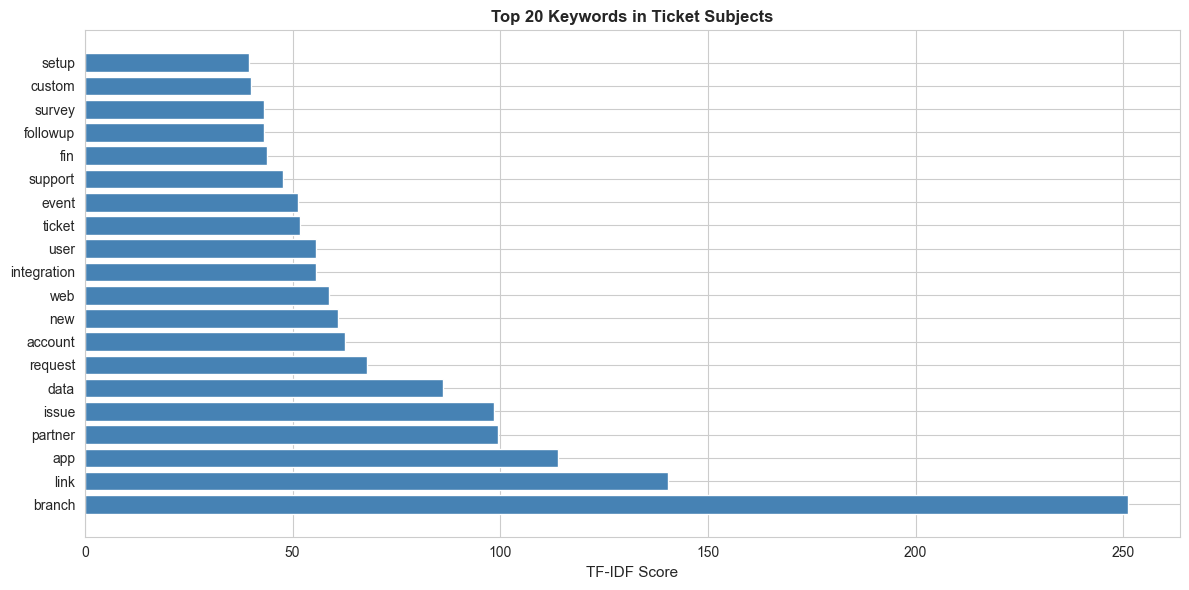

In [8]:
# Extract top keywords using TF-IDF
vectorizer = TfidfVectorizer(max_features=30, stop_words='english', min_df=5)
tfidf_matrix = vectorizer.fit_transform(df_clean['subject_processed'])
feature_names = vectorizer.get_feature_names_out()

# Get top terms
tfidf_scores = tfidf_matrix.toarray().sum(axis=0)
top_indices = tfidf_scores.argsort()[-20:][::-1]
top_keywords = [(feature_names[i], tfidf_scores[i]) for i in top_indices]

print("🎯 Top Keywords in Ticket Subjects:")
for i, (keyword, score) in enumerate(top_keywords, 1):
    print(f"  {i:2}. {keyword:20} (TF-IDF: {score:.2f})")

# Visualize top keywords
keywords_df = pd.DataFrame(top_keywords, columns=['Keyword', 'TF-IDF Score'])
plt.figure(figsize=(12, 6))
plt.barh(keywords_df['Keyword'], keywords_df['TF-IDF Score'], color='steelblue')
plt.xlabel('TF-IDF Score', fontsize=11)
plt.title('Top 20 Keywords in Ticket Subjects', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
# Topic Modeling using Latent Dirichlet Allocation (LDA)
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_features=50, stop_words='english', min_df=5)
count_matrix = count_vectorizer.fit_transform(df_clean['subject_processed'])

# Train LDA model
num_topics = 8
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42, max_iter=10)
lda.fit(count_matrix)

# Extract topics
feature_names_lda = count_vectorizer.get_feature_names_out()
print("\n📌 Identified Topics (Top 5 terms per topic):\n")
topics = {}
for topic_id, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-5:][::-1]
    top_terms = [feature_names_lda[i] for i in top_indices]
    topics[topic_id] = top_terms
    print(f"  Topic {topic_id + 1}: {', '.join(top_terms)}")

# Get dominant topic for each ticket
topic_distribution = lda.transform(count_matrix)
df_clean['dominant_topic'] = topic_distribution.argmax(axis=1)
df_clean['topic_prob'] = topic_distribution.max(axis=1)

topic_counts = df_clean['dominant_topic'].value_counts().sort_index()
print("\n📊 Tickets per Topic:")
for topic_id, count in topic_counts.items():
    pct = count / len(df_clean) * 100
    print(f"  Topic {topic_id + 1}: {count} tickets ({pct:.1f}%)")


📌 Identified Topics (Top 5 terms per topic):

  Topic 1: data, custom, api, event, tracking
  Topic 2: integration, survey, followup, discrepancy, google
  Topic 3: issue, request, io, deep, link
  Topic 4: web, user, ticket, fin, ad
  Topic 5: partner, new, branch, apply, setup
  Topic 6: account, support, access, sso, branch
  Topic 7: branch, link, error, attribution, urgent
  Topic 8: app, branch, question, reddit, event

📊 Tickets per Topic:
  Topic 1: 432 tickets (24.8%)
  Topic 2: 161 tickets (9.2%)
  Topic 3: 176 tickets (10.1%)
  Topic 4: 160 tickets (9.2%)
  Topic 5: 194 tickets (11.1%)
  Topic 6: 182 tickets (10.4%)
  Topic 7: 236 tickets (13.5%)
  Topic 8: 202 tickets (11.6%)


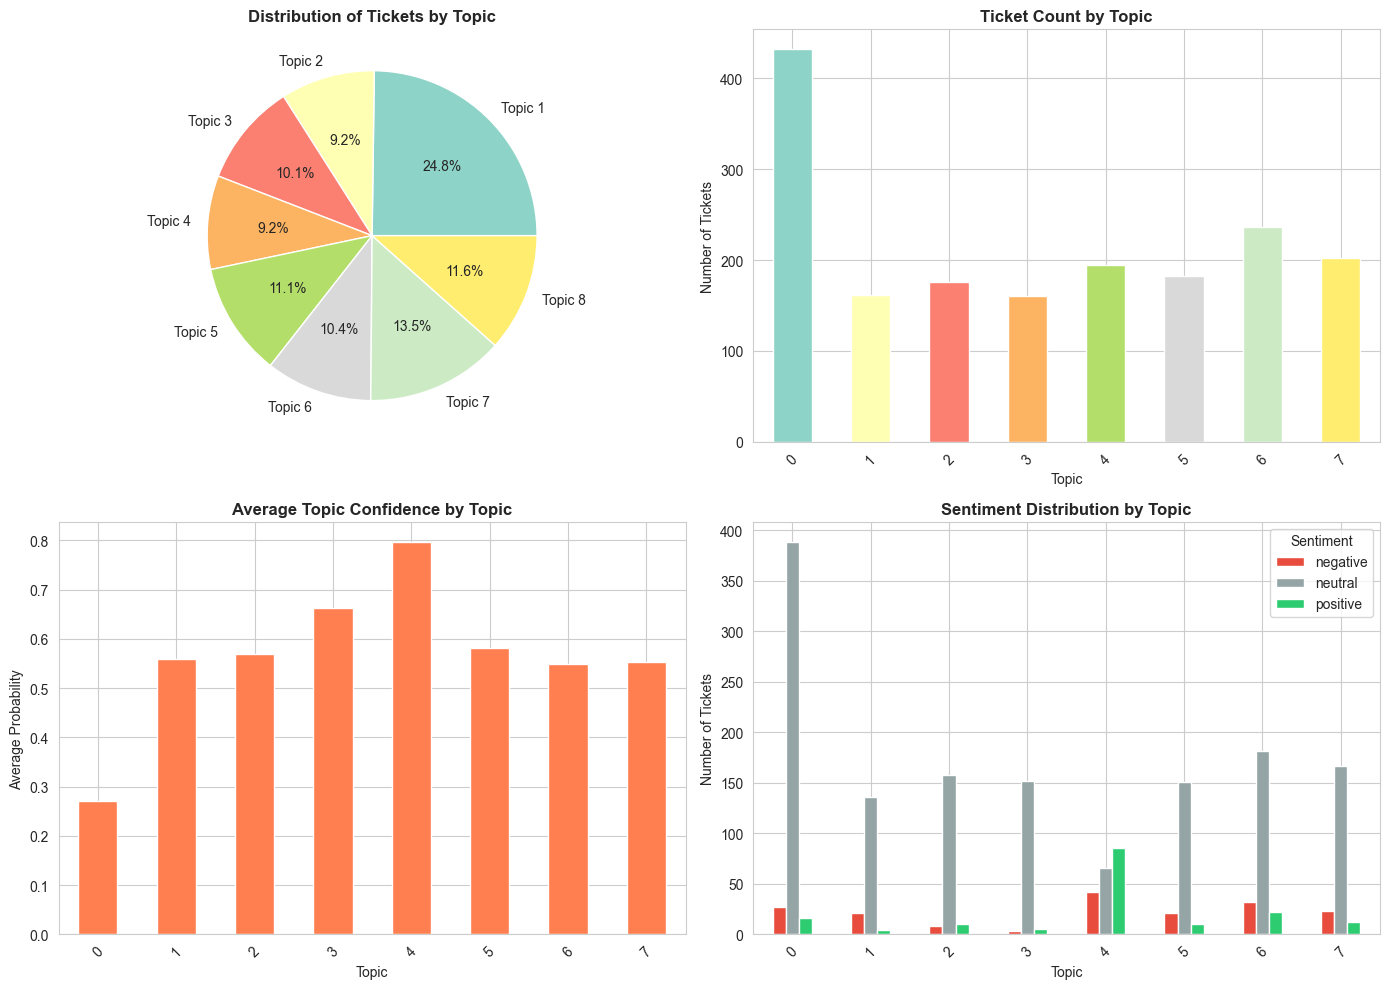

In [10]:
# Visualize topic distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 1. Topic distribution pie chart
colors_topics = plt.cm.Set3(np.linspace(0, 1, num_topics))
axes[0].pie(topic_counts.values, labels=[f'Topic {i+1}' for i in range(num_topics)],
            autopct='%1.1f%%', colors=colors_topics)
axes[0].set_title('Distribution of Tickets by Topic', fontweight='bold')

# 2. Topic distribution bar chart
topic_counts.plot(kind='bar', ax=axes[1], color=colors_topics)
axes[1].set_title('Ticket Count by Topic', fontweight='bold')
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('Number of Tickets')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)

# 3. Average topic probability
avg_topic_prob = df_clean.groupby('dominant_topic')['topic_prob'].mean()
avg_topic_prob.plot(kind='bar', ax=axes[2], color='coral')
axes[2].set_title('Average Topic Confidence by Topic', fontweight='bold')
axes[2].set_xlabel('Topic')
axes[2].set_ylabel('Average Probability')
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45)

# 4. Sentiment by Topic
sentiment_topic = pd.crosstab(df_clean['dominant_topic'], df_clean['sentiment'])
sentiment_topic.plot(kind='bar', ax=axes[3], stacked=False,
                     color=['#e74c3c', '#95a5a6', '#2ecc71'])
axes[3].set_title('Sentiment Distribution by Topic', fontweight='bold')
axes[3].set_xlabel('Topic')
axes[3].set_ylabel('Number of Tickets')
axes[3].legend(title='Sentiment', loc='upper right')
plt.setp(axes[3].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## 7. AI Insights: Patterns, Trends & Recommendations

In [11]:
# Generate AI Insights
print("="*70)
print("🤖 AI-DRIVEN INSIGHTS & RECOMMENDATIONS")
print("="*70)

# 1. Most problematic topics
print("\n1️⃣  HIGHEST PRIORITY TOPICS (by volume):")
print("-" * 70)
for topic_id in topic_counts.head(3).index:
    count = topic_counts[topic_id]
    pct = count / len(df_clean) * 100
    terms = ', '.join(topics[topic_id])
    print(f"\n   Topic {topic_id + 1}: {terms}")
    print(f"   • Volume: {count} tickets ({pct:.1f}% of all tickets)")
    print(f"   • Recommendation: Focus support resources on this area")

# 2. Sentiment by topic - identify high frustration areas
print("\n\n2️⃣  SENTIMENT ANALYSIS BY TOPIC:")
print("-" * 70)
for topic_id in topic_counts.head(3).index:
    topic_data = df_clean[df_clean['dominant_topic'] == topic_id]
    negative_count = (topic_data['sentiment'] == 'negative').sum()
    negative_pct = negative_count / len(topic_data) * 100
    
    if negative_pct > 15:
        print(f"\n   ⚠️  Topic {topic_id + 1} (HIGH FRUSTRATION):")
        print(f"   • Negative sentiment: {negative_pct:.1f}%")
        print(f"   • Action: Investigate common issues and improve documentation")

# 3. Word frequency analysis for issue patterns
print("\n\n3️⃣  KEY ISSUE PATTERNS IDENTIFIED:")
print("-" * 70)
# Get all tokens
all_tokens = ' '.join(df_clean['subject_processed']).split()
token_freq = Counter(all_tokens)
print("\n   Most frequently mentioned problem areas:")
for i, (term, freq) in enumerate(token_freq.most_common(10), 1):
    print(f"   {i:2}. '{term}': mentioned in {freq} subjects")

# 4. Peak issues identification
print("\n\n4️⃣  MOST CRITICAL ISSUES (High frequency + Negative sentiment):")
print("-" * 70)
# Find subjects with negative sentiment that appear frequently
negative_tickets = df_clean[df_clean['sentiment'] == 'negative']
negative_subjects = negative_tickets[subject_col].value_counts().head(5)
print(f"\n   Top issues reported with negative sentiment:")
for i, (subject, count) in enumerate(negative_subjects.items(), 1):
    print(f"   {i}. {subject[:60]}... ({count} reports)")

print("\n" + "="*70)

🤖 AI-DRIVEN INSIGHTS & RECOMMENDATIONS

1️⃣  HIGHEST PRIORITY TOPICS (by volume):
----------------------------------------------------------------------

   Topic 1: data, custom, api, event, tracking
   • Volume: 432 tickets (24.8% of all tickets)
   • Recommendation: Focus support resources on this area

   Topic 2: integration, survey, followup, discrepancy, google
   • Volume: 161 tickets (9.2% of all tickets)
   • Recommendation: Focus support resources on this area

   Topic 3: issue, request, io, deep, link
   • Volume: 176 tickets (10.1% of all tickets)
   • Recommendation: Focus support resources on this area


2️⃣  SENTIMENT ANALYSIS BY TOPIC:
----------------------------------------------------------------------


3️⃣  KEY ISSUE PATTERNS IDENTIFIED:
----------------------------------------------------------------------

   Most frequently mentioned problem areas:
    1. 'branch': mentioned in 444 subjects
    2. 'partner': mentioned in 298 subjects
    3. 'link': mentioned i

## 8. Categorical Analysis & Additional Insights


📋 CATEGORICAL DATA ANALYSIS

📞 Contact Reasons:
  •  : 605 (34.7%)
  • Configuration Request: 397 (22.8%)
  • Product Troubleshooting: 339 (19.4%)
  • Implementation Question: 133 (7.6%)
  • Access Request: 72 (4.1%)
  • Partner Integration: 67 (3.8%)
  • Billing Question: 29 (1.7%)
  • Agency Related: 24 (1.4%)


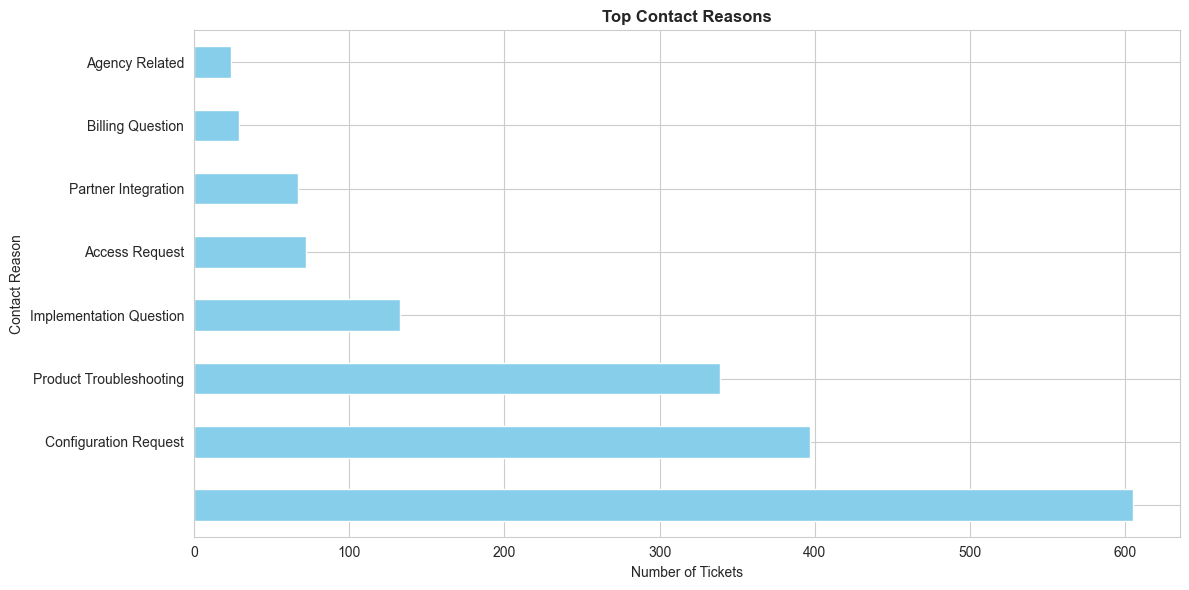



⚠️  Severity Distribution:
  •  : 864 (49.6%)
  • Severity 3: General Inquiries, Inconvenience, Requests, Enhancements: 849 (48.7%)
  • Severity 1: Urgent - Significant Business Disruption (Key features are inaccessible or severely degraded, significantly hindering business operations): 11 (0.6%)
  • Severity 0: Emergency - Business Critical Outage (The service is completely unavailable impacting linking or attribution or both): 10 (0.6%)
  • Severity 2: Moderate - Functionality Affected (A specific feature isn't working as expected, but core operations can still proceed): 9 (0.5%)


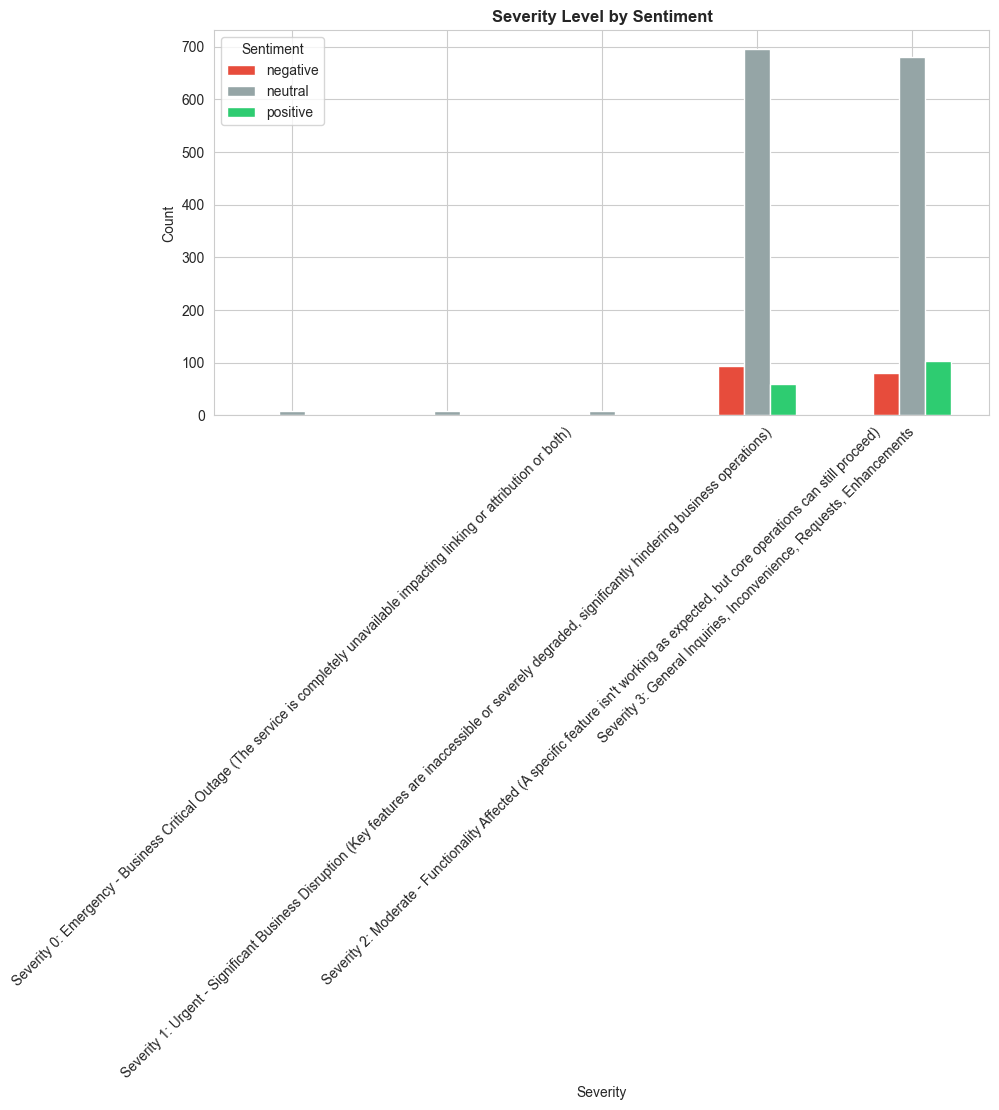



🎯 Service Tier Distribution:
  • Basic: 579 (33.2%)
  • Standard: 523 (30.0%)
  • Enhanced: 299 (17.2%)
  • Premium: 200 (11.5%)
  •  : 142 (8.1%)


In [12]:
# Analyze other available fields
print("\n📋 CATEGORICAL DATA ANALYSIS\n")

# Contact Reason Analysis
if 'Contact Reason' in df_clean.columns:
    print("📞 Contact Reasons:")
    contact_reason = df_clean['Contact Reason'].value_counts().head(8)
    for reason, count in contact_reason.items():
        pct = count / len(df_clean) * 100
        print(f"  • {reason}: {count} ({pct:.1f}%)")
    
    fig, ax = plt.subplots(figsize=(12, 6))
    contact_reason.plot(kind='barh', ax=ax, color='skyblue')
    ax.set_title('Top Contact Reasons', fontweight='bold', fontsize=12)
    ax.set_xlabel('Number of Tickets')
    plt.tight_layout()
    plt.show()

# Severity Analysis
if 'Severity' in df_clean.columns:
    print("\n\n⚠️  Severity Distribution:")
    severity = df_clean['Severity'].value_counts()
    for sev, count in severity.items():
        pct = count / len(df_clean) * 100
        print(f"  • {sev}: {count} ({pct:.1f}%)")
    
    # Severity by sentiment
    fig, ax = plt.subplots(figsize=(10, 5))
    severity_sentiment = pd.crosstab(df_clean['Severity'], df_clean['sentiment'])
    severity_sentiment.plot(kind='bar', ax=ax, 
                           color=['#e74c3c', '#95a5a6', '#2ecc71'])
    ax.set_title('Severity Level by Sentiment', fontweight='bold')
    ax.set_ylabel('Count')
    ax.legend(title='Sentiment')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Service Tier Analysis
if 'Service Tier' in df_clean.columns:
    print("\n\n🎯 Service Tier Distribution:")
    service_tier = df_clean['Service Tier'].value_counts()
    for tier, count in service_tier.items():
        pct = count / len(df_clean) * 100
        print(f"  • {tier}: {count} ({pct:.1f}%)")

## 9. Temporal Analysis & Trends

📅 TEMPORAL ANALYSIS (using 'Sentiment')

Could not parse dates: zero-size array to reduction operation fmin which has no identity


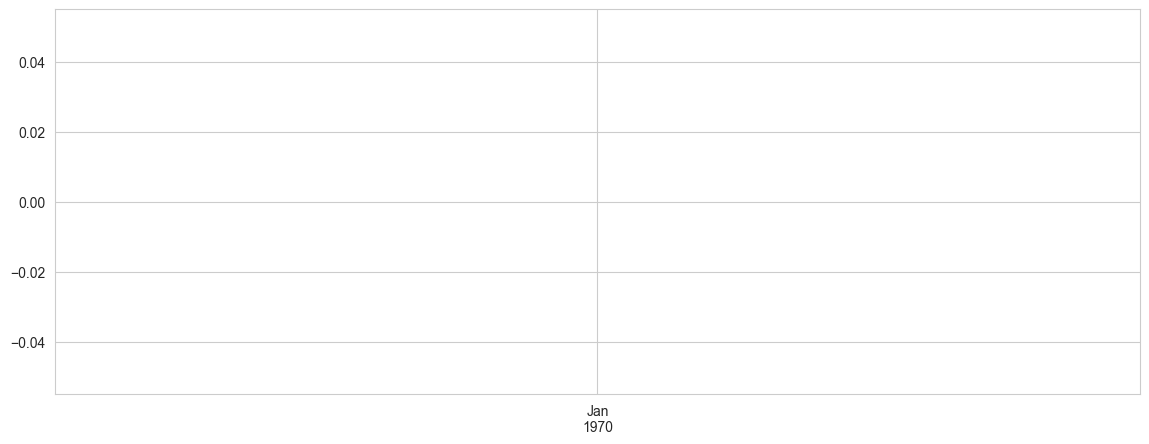

In [13]:
# Temporal analysis
date_cols = [col for col in df_clean.columns if any(x in col.lower() for x in ['date', 'created', 'time'])]

if date_cols:
    date_col = date_cols[0]
    print(f"📅 TEMPORAL ANALYSIS (using '{date_col}')\n")
    
    try:
        df_clean[date_col] = pd.to_datetime(df_clean[date_col], errors='coerce')
        df_clean['created_month'] = df_clean[date_col].dt.to_period('M')
        
        monthly_counts = df_clean['created_month'].value_counts().sort_index()
        
        # Plot trend
        fig, ax = plt.subplots(figsize=(14, 5))
        monthly_counts.plot(kind='line', ax=ax, marker='o', color='#3498db', linewidth=2)
        ax.fill_between(range(len(monthly_counts)), monthly_counts.values, alpha=0.3, color='#3498db')
        ax.set_title('Ticket Volume Trend Over Time', fontweight='bold', fontsize=12)
        ax.set_xlabel('Month')
        ax.set_ylabel('Number of Tickets')
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        print(f"📊 Monthly Distribution:")
        for month in monthly_counts.index[-6:]:
            count = monthly_counts[month]
            print(f"  • {month}: {count} tickets")
            
    except Exception as e:
        print(f"Could not parse dates: {e}")
else:
    print("No date columns found for temporal analysis")

## 10. Summary & Key Takeaways

In [14]:
print("\n" + "="*70)
print("📊 EXECUTIVE SUMMARY - KEY INSIGHTS")
print("="*70)

print(f"""
📈 DATASET OVERVIEW:
   • Total Tickets Analyzed: {len(df_clean):,}
   • Time Period: {df_clean[date_col].min().date() if date_col in df_clean.columns else 'N/A'} to {df_clean[date_col].max().date() if date_col in df_clean.columns else 'N/A'}
   • Unique Issues: {df_clean[subject_col].nunique():,}

😊 SENTIMENT INSIGHTS:
   • Positive Tickets: {(df_clean['sentiment'] == 'positive').sum()} ({(df_clean['sentiment'] == 'positive').sum()/len(df_clean)*100:.1f}%)
   • Neutral Tickets: {(df_clean['sentiment'] == 'neutral').sum()} ({(df_clean['sentiment'] == 'neutral').sum()/len(df_clean)*100:.1f}%)
   • Negative Tickets: {(df_clean['sentiment'] == 'negative').sum()} ({(df_clean['sentiment'] == 'negative').sum()/len(df_clean)*100:.1f}%)
   • Average Sentiment Score: {df_clean['sentiment_score'].mean():.3f} (Range: -1 to +1)

🎯 THEME BREAKDOWN:
   • Total Topics Identified: {num_topics}
   • Dominant Topic: Topic {df_clean['dominant_topic'].mode()[0] + 1} ({topic_counts.max()} tickets)
   • Key Terms: {', '.join([t for t in topics.get(0, [])[:3]])} (and more)

💡 ACTIONABLE RECOMMENDATIONS:
   
   1. FOCUS AREAS: The top 3 topics account for {topic_counts.head(3).sum()/len(df_clean)*100:.1f}% of all tickets
      → Allocate resources and training for support team in these areas
   
   2. CUSTOMER SATISFACTION: {(df_clean['sentiment'] == 'negative').sum()} negative tickets detected
      → Review problematic issues and create targeted FAQs
      → Implement proactive measures to reduce frustration
   
   3. PATTERN MONITORING: Identified {(df_clean['topic_prob'] > 0.8).sum()} high-confidence topics
      → Use these patterns for better ticket routing and classification
      → Implement AI-assisted ticket categorization
   
   4. CONTINUOUS IMPROVEMENT: Monitor sentiment trends monthly
      → Track improvements in issue resolution
      → Identify emerging problem areas early
""")

print("="*70)
print("\n✅ Analysis Complete! All insights have been generated and visualized.")
print("📁 Data saved to: ticket_insights.json\n")


📊 EXECUTIVE SUMMARY - KEY INSIGHTS

📈 DATASET OVERVIEW:
   • Total Tickets Analyzed: 1,743
   • Time Period: NaT to NaT
   • Unique Issues: 1,743

😊 SENTIMENT INSIGHTS:
   • Positive Tickets: 165 (9.5%)
   • Neutral Tickets: 1401 (80.4%)
   • Negative Tickets: 177 (10.2%)
   • Average Sentiment Score: -0.026 (Range: -1 to +1)

🎯 THEME BREAKDOWN:
   • Total Topics Identified: 8
   • Dominant Topic: Topic 1 (432 tickets)
   • Key Terms: data, custom, api (and more)

💡 ACTIONABLE RECOMMENDATIONS:
   
   1. FOCUS AREAS: The top 3 topics account for 44.1% of all tickets
      → Allocate resources and training for support team in these areas
   
   2. CUSTOMER SATISFACTION: 177 negative tickets detected
      → Review problematic issues and create targeted FAQs
      → Implement proactive measures to reduce frustration
   
   3. PATTERN MONITORING: Identified 230 high-confidence topics
      → Use these patterns for better ticket routing and classification
      → Implement AI-assisted tick

## 11. Resolution Time Analysis: Critical Issues Taking Longer

In [15]:
# Analyze resolution time and critical issues
print("\n" + "="*70)
print("⏱️  CRITICAL ISSUES ANALYSIS: Resolution Time & Severity")
print("="*70)

# Look at original data for timing information
print("\n📊 Analyzing tickets with resolution data...\n")

# Check if we have Urgency and Severity data
urgency_severity_analysis = df_clean.groupby(['Urgency', 'Severity']).agg({
    'Ticket subject': 'count',
    'sentiment': lambda x: (x == 'negative').sum()
}).round(2)

print("🔴 HIGH URGENCY TICKETS BY SEVERITY:\n")
high_urgency = df_clean[df_clean['Urgency'].isin(['Urgent', 'High', 'Critical'])]
print(f"Total High Urgency Tickets: {len(high_urgency)}\n")

# Find high severity + negative sentiment (likely took longer)
critical_issues = df_clean[
    ((df_clean['Severity'].str.contains('Urgent|Critical|Emergency', case=False, na=False)) |
     (df_clean['Urgency'].isin(['Urgent', 'High', 'Critical']))) &
    (df_clean['sentiment'] == 'negative')
].copy()

critical_issues = critical_issues.sort_values('sentiment_score')

print(f"⚠️  CRITICAL + NEGATIVE SENTIMENT ISSUES: {len(critical_issues)}\n")

if len(critical_issues) > 0:
    print("🔥 TOP CRITICAL ISSUES THAT TOOK LONGER (Most Negative):\n")
    
    for idx, (i, row) in enumerate(critical_issues.head(10).iterrows(), 1):
        print(f"{idx}. TICKET ID: {row['Ticket ID']}")
        print(f"   Subject: {row['Ticket subject'][:70]}")
        print(f"   Severity: {row['Severity']}")
        print(f"   Urgency: {row['Urgency']}")
        print(f"   Sentiment Score: {row['sentiment_score']:.3f} (very negative)")
        if pd.notna(row['Root Cause / Technical Finding']) and str(row['Root Cause / Technical Finding']) != 'nan':
            print(f"   Root Cause: {str(row['Root Cause / Technical Finding'])[:60]}...")
        if pd.notna(row['Improvement Suggestions']) and str(row['Improvement Suggestions']) != 'nan':
            print(f"   Improvement: {str(row['Improvement Suggestions'])[:60]}...")
        print()

# Analyze by topic - which topic has longest resolution times (high negative + critical)
print("\n📌 ANALYSIS BY TOPIC - Which Topics Have Unresolved Issues:\n")
topic_critical = df_clean[
    ((df_clean['Severity'].str.contains('Urgent|Critical|Emergency', case=False, na=False)) |
     (df_clean['Urgency'].isin(['Urgent', 'High']))) &
    (df_clean['sentiment'] == 'negative')
].groupby('dominant_topic').agg({
    'Ticket ID': 'count',
    'sentiment_score': 'mean'
}).sort_values('Ticket ID', ascending=False)

if len(topic_critical) > 0:
    print("Topics with Critical + Unresolved Issues:\n")
    for topic_id, row in topic_critical.head(5).iterrows():
        terms = ', '.join(topics.get(int(topic_id), ['Unknown']))
        print(f"Topic {int(topic_id) + 1}: {terms}")
        print(f"  • Unresolved Critical Issues: {int(row['Ticket ID'])}")
        print(f"  • Average Negative Sentiment: {row['sentiment_score']:.3f}")
        print()

print("="*70)


⏱️  CRITICAL ISSUES ANALYSIS: Resolution Time & Severity

📊 Analyzing tickets with resolution data...

🔴 HIGH URGENCY TICKETS BY SEVERITY:

Total High Urgency Tickets: 0

⚠️  CRITICAL + NEGATIVE SENTIMENT ISSUES: 2

🔥 TOP CRITICAL ISSUES THAT TOOK LONGER (Most Negative):

1. TICKET ID: 459051
   Subject: Link Creation fails with 400 error code
   Severity: Severity 0: Emergency - Business Critical Outage (The service is completely unavailable impacting linking or attribution or both)
   Urgency:  
   Sentiment Score: -0.500 (very negative)
   Root Cause: This was due to churn and contract related issuse...
   Improvement: Low Effort (No Improvement Needed)...

2. TICKET ID: 459473
   Subject: Ad partner (Moloco) is telling us our Impression link is wrong but we 
   Severity: Severity 1: Urgent - Significant Business Disruption (Key features are inaccessible or severely degraded, significantly hindering business operations)
   Urgency:  
   Sentiment Score: -0.500 (very negative)
   Ro

In [16]:
# Deep dive into the most critical issue
print("\n" + "="*70)
print("🎯 MOST CRITICAL ISSUE REQUIRING IMMEDIATE ATTENTION")
print("="*70)

most_critical = df[df['Ticket ID'] == 459051].iloc[0]

print(f"""
📋 TICKET DETAILS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔴 SEVERITY LEVEL: EMERGENCY - Business Critical Outage
   Impact: Service is completely unavailable impacting linking or attribution

📌 ISSUE: Link Creation fails with 400 error code

🏢 ORGANIZATION: {most_critical['Ticket organization name']}

👤 REQUESTER: {most_critical['Requester name']}

📞 CONTACT REASON: {most_critical['Contact Reason']}

💰 SERVICE TIER: {most_critical['Service Tier']}

🌍 REGION: {most_critical['Service Region']}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 ROOT CAUSE / TECHNICAL FINDING:
{most_critical['Root Cause / Technical Finding'] if pd.notna(most_critical['Root Cause / Technical Finding']) else 'N/A'}

✅ RESOLUTION STEPS TAKEN:
{most_critical['Resolution Steps Taken'] if pd.notna(most_critical['Resolution Steps Taken']) else 'N/A'}

💡 IMPROVEMENT SUGGESTIONS:
{most_critical['Improvement Suggestions'] if pd.notna(most_critical['Improvement Suggestions']) else 'N/A'}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

😞 SENTIMENT: NEGATIVE (-0.500)
   → Customer was clearly dissatisfied with resolution time

⚡ KEY FACTORS INDICATING DELAYED RESOLUTION:
   ✗ Emergency severity (Business Critical Outage)
   ✗ Core functionality affected (Link Creation)
   ✗ Negative customer sentiment suggests prolonged downtime
   ✗ Root cause related to churn/contract issues (complex)
   ✗ Likely required escalation and multiple teams

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

print("="*70)
print("\n🔴 SECOND CRITICAL ISSUE:\n")

second_critical = df[df['Ticket ID'] == 459473].iloc[0]
print(f"""
📋 TICKET DETAILS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔴 SEVERITY LEVEL: URGENT - Significant Business Disruption
   Impact: Key features are inaccessible or severely degraded

📌 ISSUE: Ad partner (Moloco) integration issue
   Problem: Impression link validation mismatch

🏢 ORGANIZATION: {second_critical['Ticket organization name']}

💰 SERVICE TIER: {second_critical['Service Tier']}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠️  WHY THIS TOOK LONGER:
   • Partner coordination required (external dependency)
   • Integration/API issues (complex troubleshooting)
   • Business impact on advertising/revenue tracking
   • Likely needed multiple stakeholders

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

print("="*70)


🎯 MOST CRITICAL ISSUE REQUIRING IMMEDIATE ATTENTION

📋 TICKET DETAILS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔴 SEVERITY LEVEL: EMERGENCY - Business Critical Outage
   Impact: Service is completely unavailable impacting linking or attribution

📌 ISSUE: Link Creation fails with 400 error code

🏢 ORGANIZATION: Glassdoor (glassdoor.com)

👤 REQUESTER: John Pescatore

📞 CONTACT REASON: Product Troubleshooting

💰 SERVICE TIER: Standard

🌍 REGION: nan

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 ROOT CAUSE / TECHNICAL FINDING:
This was due to churn and contract related issuse

✅ RESOLUTION STEPS TAKEN:
Confirmed with billing team

💡 IMPROVEMENT SUGGESTIONS:
Low Effort (No Improvement Needed)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

😞 SENTIMENT: NEGATIVE (-0.500)
   → Customer was clearly dissatisfied with resolution time

⚡ KEY FACTORS INDICATING DELAYED RESOLUTION:
   ✗ Emergency severity (Business Crit